In [1]:
!pip install transformers

In [2]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project

/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project/Model')

from Utils import *

In [7]:
import random
import numpy as np
import torch

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # for CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # for reproducibility

set_seed(123)

# Training

In [8]:
data_path = "Final/en_dataset.xlsx"
train_data_path = "Final/train.xlsx"
val_data_path = "Final/val.xlsx"
test_data_path = 'Final/test.xlsx'
sheet_name = "Sheet1"

In [9]:
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = SocialMediaDS(
    data_path=train_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)

val_ds = SocialMediaDS(
    data_path=val_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

test_ds = SocialMediaDS(
    data_path=test_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
test_dl = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
print(f'Size of training data: {len(train_ds)}')
print(f'Size of validation data: {len(val_ds)}')
print(f'Size of validation data: {len(test_ds)}')

Size of training data: 1272
Size of validation data: 71
Size of validation data: 71


In [11]:
model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [12]:
epochs = 5
loss_fn = focal_loss(2)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [13]:
mem = train_and_validate(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    model_save_path="Model/saved_models/model_masked.pth",
    epochs=5
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 2.024	Acc: 0.306	F1: 0.314
Val Loss:   1.095	Acc:   0.559	F1:   0.577

New best F1: 0.577 - Model saved!
Epoch 2/5
Train Loss: 1.207	Acc: 0.492	F1: 0.500
Val Loss:   1.153	Acc:   0.482	F1:   0.505

Epoch 3/5
Train Loss: 0.759	Acc: 0.654	F1: 0.666
Val Loss:   1.251	Acc:   0.589	F1:   0.590

New best F1: 0.590 - Model saved!
Epoch 4/5
Train Loss: 0.623	Acc: 0.703	F1: 0.712
Val Loss:   1.474	Acc:   0.514	F1:   0.519

Epoch 5/5
Train Loss: 0.422	Acc: 0.775	F1: 0.790
Val Loss:   1.493	Acc:   0.511	F1:   0.507

Training completed!


# Evaluation

In [14]:
emo_preds, emo_targets, all_texts = evaluate_model(model, test_ds, test_dl)

  0%|          | 0/5 [00:00<?, ?it/s]

                precision    recall  f1-score   support
0                   50.00     30.00     37.50        10
1                   40.00     50.00     44.44         8
2                   87.50     70.00     77.78        10
3                   68.75    100.00     81.48        11
4                   70.00     63.64     66.67        11
5                   66.67     60.00     63.16        10
6                   66.67     72.73     69.57        11

accuracy                                64.79        71
macro avg           64.23     63.77     62.94        71
weighted avg        65.09     64.79     63.87        71


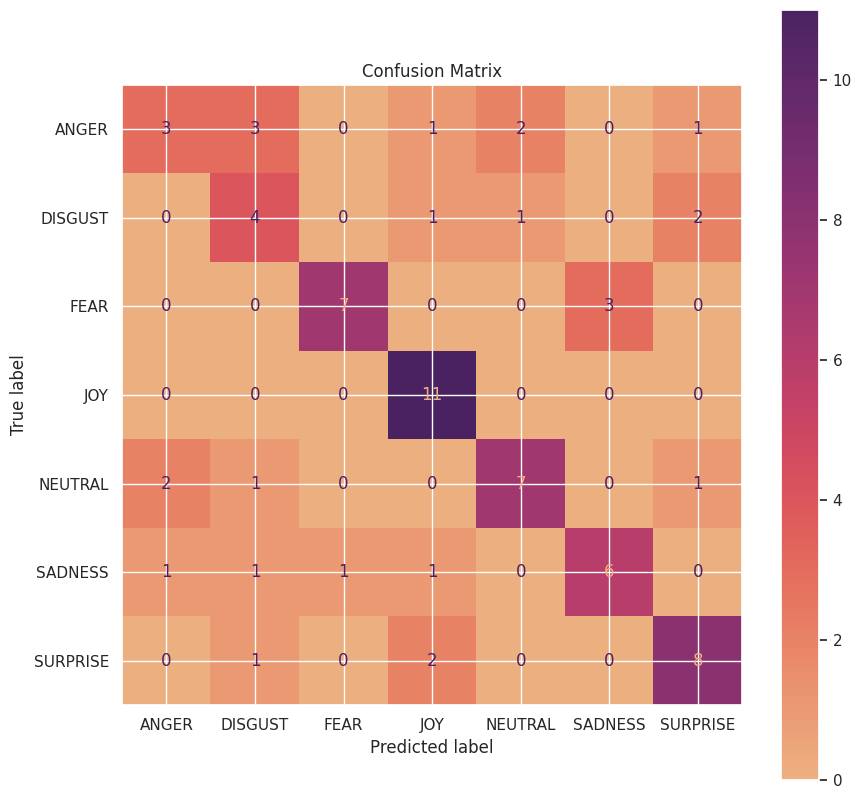

In [15]:
plot_confusion_matrix(emo_preds, emo_targets)

# Severity Analysis

In [16]:
misclassified_df = analyze_misclassifications(emo_preds, emo_targets, all_texts)

In [17]:
misclassified_df.head()

,Text,True Emotion,Predicted Emotion,Severity
0,"will get. and since we are a service economy, ...",ANGER,SURPRISE,Severe Misclassification
1,taking time to build all this infrastructures ...,FEAR,FEAR,Correct
2,jobs perceived ( rightly or wrongly ) by local...,NEUTRAL,NEUTRAL,Correct
3,anthony pang some young msian engineer are get...,ANGER,ANGER,Correct
4,china ones but neither do i trust us or uk or ...,NEUTRAL,DISGUST,Moderate Misclassification


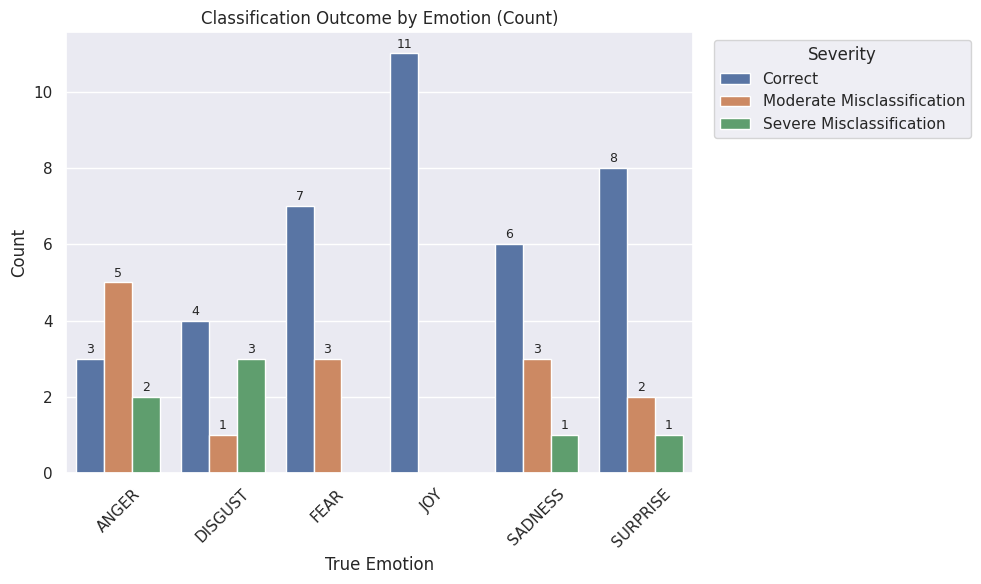

In [18]:
plot_severity_bar(misclassified_df)